In [45]:
# Install PySpark jika belum diinstal
!pip install pyspark

# Import libraries yang diperlukan
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, weekofyear, to_date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns


In [46]:
# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Walmart Sales Forecast") \
    .getOrCreate()

# Mount Google Drive untuk mengakses dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
# Membaca dataset CSV
train_data = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/Walmart Sales Forecast/train_data.csv', header=True, inferSchema=True)
features_data = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/Walmart Sales Forecast/features_data.csv', header=True, inferSchema=True)
stores_data = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/Walmart Sales Forecast/stores_data.csv', header=True, inferSchema=True)


In [48]:
train_data.show(5)
features_data.show(5)
stores_data.show(5)

+-----+----+----------+------------+---------+
|Store|Dept|      Date|Weekly_Sales|IsHoliday|
+-----+----+----------+------------+---------+
|    1|   1|2010-02-05|     24924.5|    false|
|    1|   1|2010-02-12|    46039.49|     true|
|    1|   1|2010-02-19|    41595.55|    false|
|    1|   1|2010-02-26|    19403.54|    false|
|    1|   1|2010-03-05|     21827.9|    false|
+-----+----+----------+------------+---------+
only showing top 5 rows
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|Store|      Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday|
+-----+----------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+---------+
|    1|2010-02-05|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|    false|
|    1|2010-02-12|      38.51|     2.548|    

In [49]:
train_data.printSchema()
features_data.printSchema()
stores_data.printSchema()


root
 |-- Store: integer (nullable = true)
 |-- Dept: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- MarkDown1: double (nullable = true)
 |-- MarkDown2: double (nullable = true)
 |-- MarkDown3: double (nullable = true)
 |-- MarkDown4: double (nullable = true)
 |-- MarkDown5: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

root
 |-- Store: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)



In [50]:
from pyspark.sql import functions as F

print("\nMissing Values in train_data:")
train_missing_values = train_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in train_data.columns])
train_missing_values.show()


Missing Values in train_data:
+-----+----+----+------------+---------+
|Store|Dept|Date|Weekly_Sales|IsHoliday|
+-----+----+----+------------+---------+
|    0|   0|   0|           0|        0|
+-----+----+----+------------+---------+



In [51]:
print("\nMissing Values in features_data:")
features_missing_values = features_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in features_data.columns])
features_missing_values.show()


Missing Values in features_data:
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|Store|Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|IsHoliday|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|    0|   0|          0|         0|        0|        0|        0|        0|        0|  0|           0|        0|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+



In [52]:
print("\nMissing Values in stores_data:")
stores_missing_values = stores_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in stores_data.columns])
stores_missing_values.show()


Missing Values in stores_data:
+-----+----+----+
|Store|Type|Size|
+-----+----+----+
|    0|   0|   0|
+-----+----+----+



In [53]:
# Memeriksa duplikasi untuk setiap DataFrame
print("\nChecking duplicates:")
train_duplicates = train_data.count() - train_data.distinct().count()
print(f"train_data: {train_duplicates}")
features_duplicates = features_data.count() - features_data.distinct().count()
print(f"features_data: {features_duplicates}")
stores_duplicates = stores_data.count() - stores_data.distinct().count()
print(f"stores_data: {stores_duplicates}")


Checking duplicates:
train_data: 0
features_data: 0
stores_data: 0


# MERGE DATA

In [135]:
# Merging the data
features_data = features_data.withColumnRenamed("IsHoliday", "IsHoliday_features")

# Merging train_data with features_data and stores_data
df = train_data.join(features_data, on=["Store", "Date"], how="left")
df = df.join(stores_data, on="Store", how="left")
df.show(5)

+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+------------------+----+------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday_features|Type|  Size|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+------------------+----+------+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|             false|   A|151315|
|    1|2010-02-12|   1|    46039.49|     true|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.2421698|       8.106|              true|   A|151315|
|    1|2010-02-19|   1|    41595.55|    false|      39.93|     2.514|      0.0|      0.0|      0.0|      0.0|      0.0|2

In [136]:
# Mengonversi kolom 'Date' menjadi datetime
df = df.withColumn("Date", to_date(df["Date"], "yyyy-MM-dd"))

# Menambahkan kolom 'Year', 'Month', 'Day', 'Week' berdasarkan kolom 'Date'
df = df.withColumn("Year", year(df["Date"]))
df = df.withColumn("Month", month(df["Date"]))
df = df.withColumn("Day", dayofmonth(df["Date"]))
df = df.withColumn("Week", weekofyear(df["Date"]))

# Menampilkan beberapa baris pertama untuk memverifikasi
df.show(5)

+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+------------------+----+------+----+-----+---+----+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday_features|Type|  Size|Year|Month|Day|Week|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+------------------+----+------+----+-----+---+----+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|             false|   A|151315|2010|    2|  5|   5|
|    1|2010-02-12|   1|    46039.49|     true|      38.51|     2.548|      0.0|      0.0|      0.0|      0.0|      0.0|211.2421698|       8.106|              true|   A|151315|2010|    2| 12|   6|
|    1|2010-02-19|  

# EDA

In [137]:
# Descriptive statistics untuk data
def describe_data(df, name):
    print(f"\n{name} Descriptive Statistics:")
    print(f"Jumlah baris  : {df.count():,}")
    print(f"Jumlah kolom  : {len(df.columns)}")
    df.describe().show()

# Menampilkan deskriptif statistik untuk Weekly_Sales dan beberapa fitur lainnya
numerical_columns = ['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
                     'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                     'CPI', 'Unemployment', 'Size', 'Year', 'Month', 'Day', 'Week']
categorical_columns = ['IsHoliday', 'Type']

In [159]:
# Menambahkan statistik tambahan (skewness dan kurtosis)
additional_stats = pd.DataFrame(index=['skewness', 'kurtosis'])
for col in numerical_columns:
    additional_stats.loc['skewness', col] = stats.skew(df.select(col).rdd.flatMap(lambda x: x).collect())
    additional_stats.loc['kurtosis', col] = stats.kurtosis(df.select(col).rdd.flatMap(lambda x: x).collect())

full_summary = pd.concat([additional_stats])
print(full_summary)

             Store      Dept  Weekly_Sales  Temperature  Fuel_Price  \
skewness  0.077762  0.358222      3.261997    -0.321403   -0.104901   
kurtosis -1.146503 -1.215570     21.491021    -0.635929   -1.185405   

          MarkDown1   MarkDown2   MarkDown3  MarkDown4   MarkDown5       CPI  \
skewness   4.731287   10.645918   14.922288   8.077638    9.964484  0.085219   
kurtosis  34.916808  145.419554  248.092414  86.241302  183.405876 -1.829707   

          Unemployment      Size      Year     Month       Day      Week  
skewness      1.183738 -0.325849  0.056236  0.040786  0.009423  0.052659  
kurtosis      2.731170 -1.206346 -1.423232 -1.110413 -1.198810 -1.111680  




NUMERICAL COLUMNS ANALYSIS
----------------------------------------


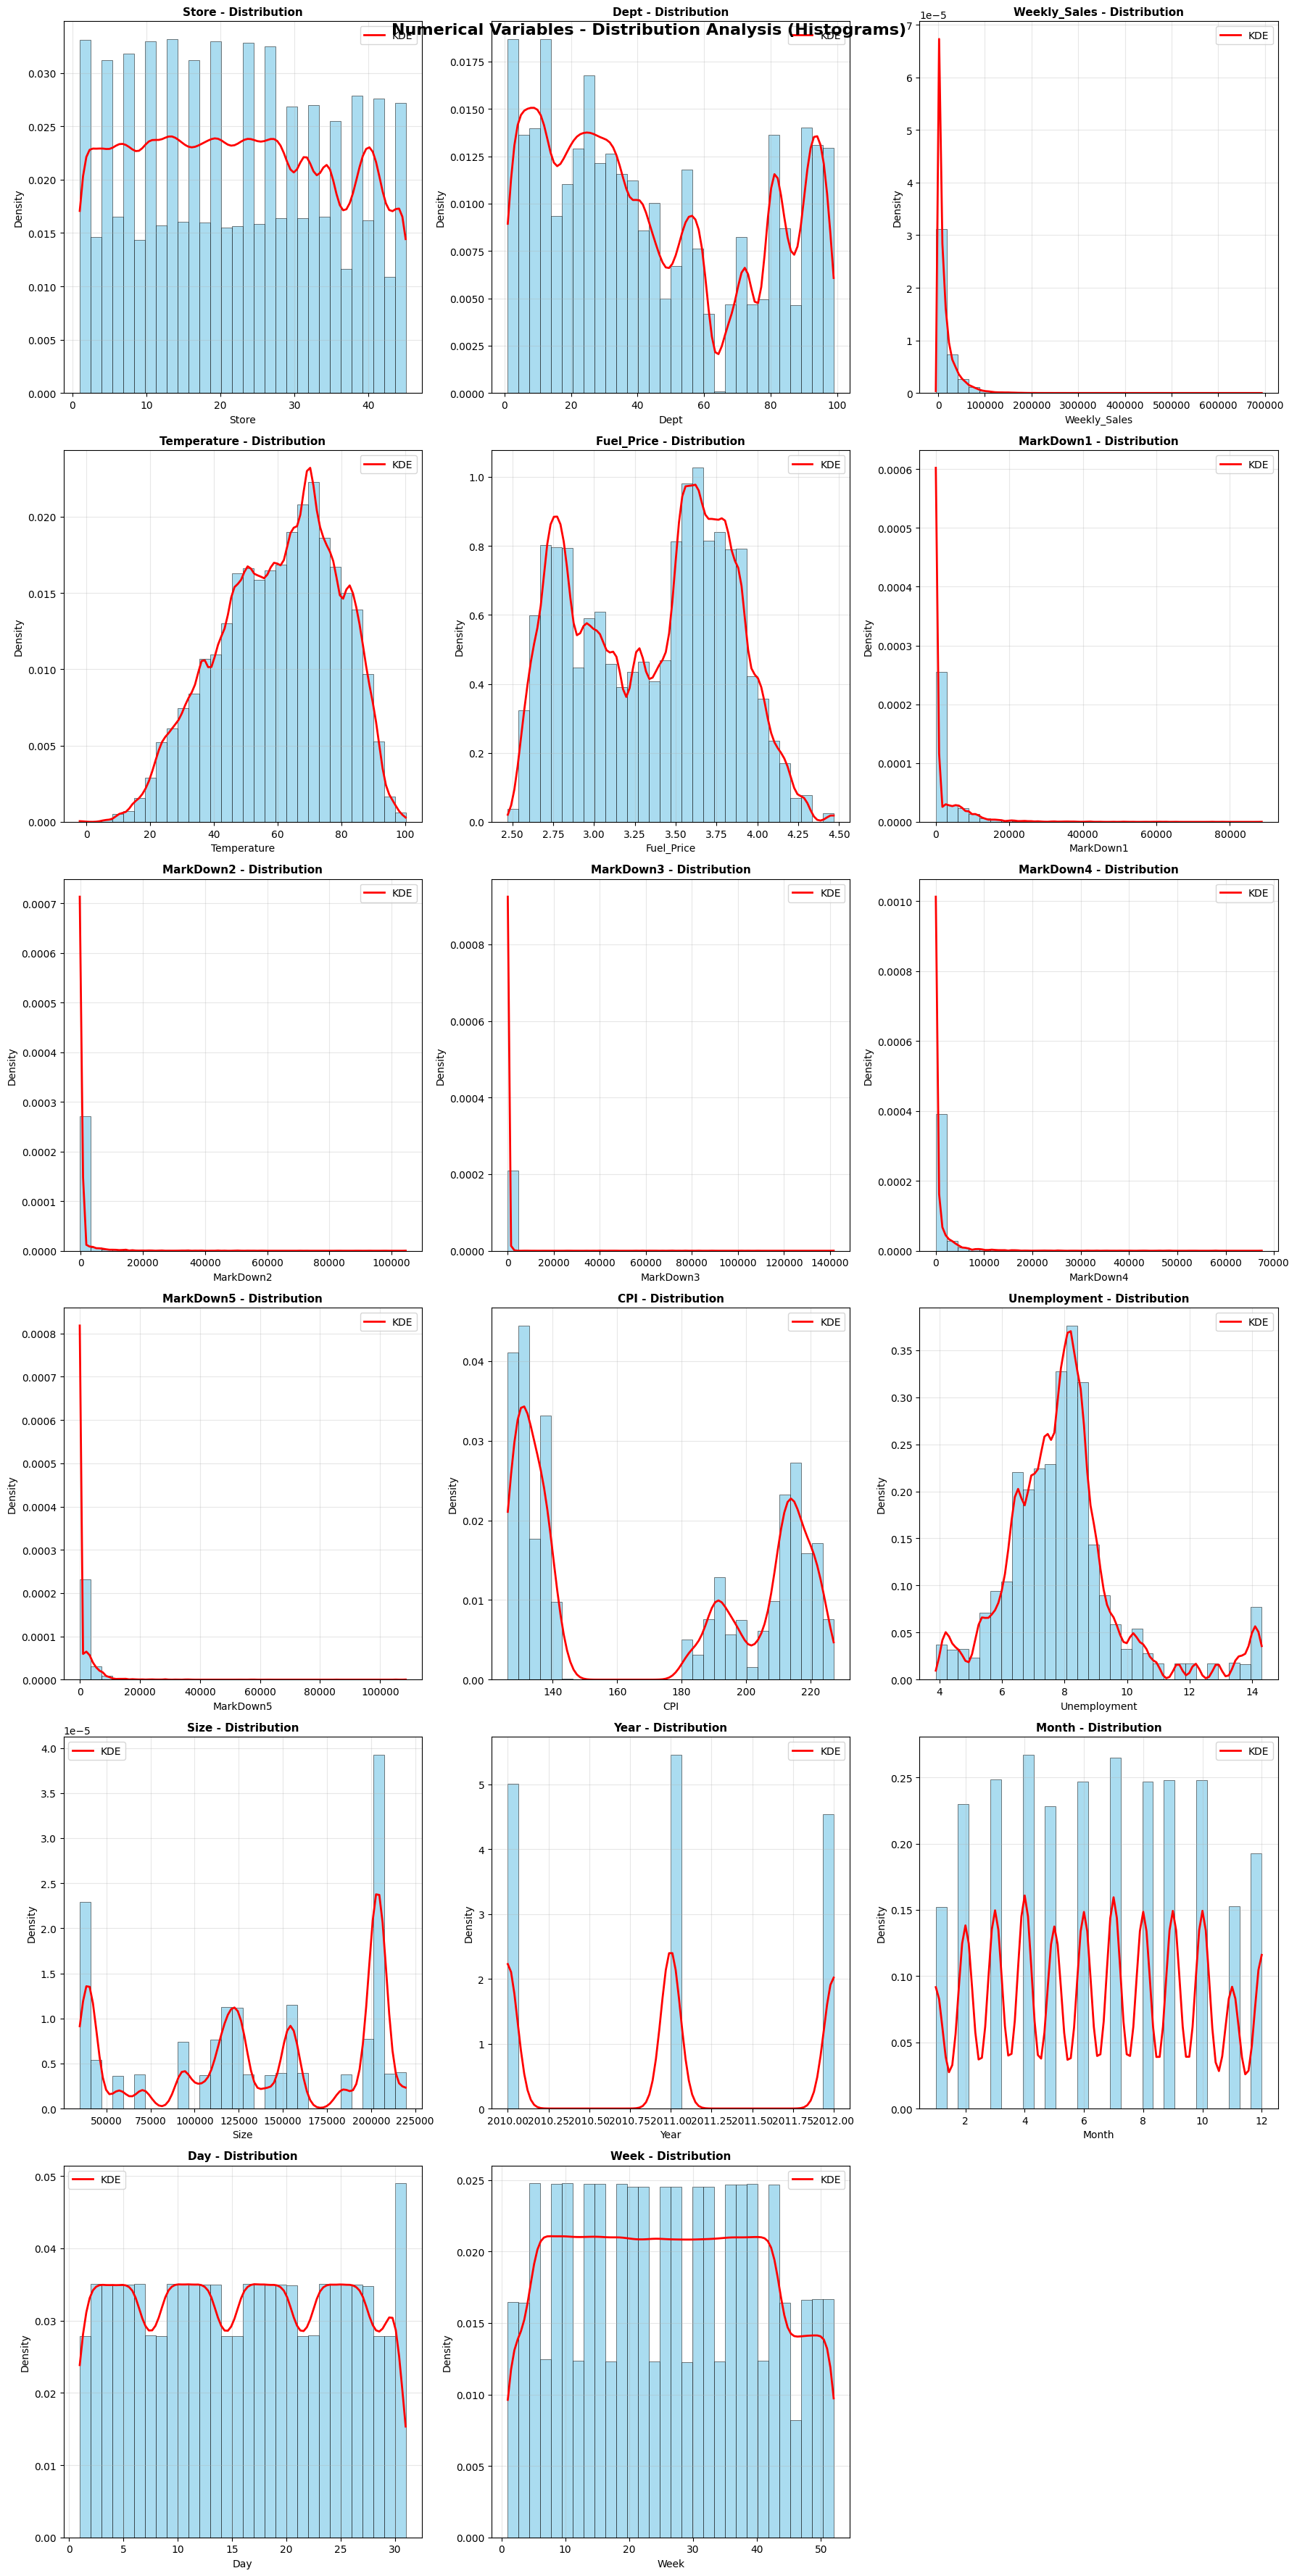

In [58]:
# Menampilkan distribusi numerik (Histograms + KDE)
if len(numerical_columns) > 0:
    print("\n\nNUMERICAL COLUMNS ANALYSIS")
    print("-" * 40)

    n_num_cols = len(numerical_columns)
    num_rows = (n_num_cols + 2) // 3  # Menghitung jumlah baris
    num_cols = 3

    # Histograms + KDE
    fig_hist, axes_hist = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
    fig_hist.suptitle('Numerical Variables - Distribution Analysis (Histograms)',
                      fontsize=16, fontweight='bold', y=0.98)

    axes_hist = axes_hist.flatten() if n_num_cols > 1 else [axes_hist]

    for i, col in enumerate(numerical_columns):
        if i < len(axes_hist):
            # Ambil data dari DataFrame PySpark untuk histogram
            data_col = df.select(col).rdd.flatMap(lambda x: x).collect()

            # Plot Histogram
            axes_hist[i].hist(data_col, bins=30, alpha=0.7, color='skyblue', density=True,
                              edgecolor='black', linewidth=0.5)

            # Menambahkan KDE
            try:
                kde_x = np.linspace(min(data_col), max(data_col), 100)
                kde = stats.gaussian_kde(data_col)
                axes_hist[i].plot(kde_x, kde(kde_x), color='red', linewidth=2, label='KDE')
            except Exception as e:
                print(f"KDE error for {col}: {e}")

            # Menambahkan detail pada grafik
            axes_hist[i].set_title(f'{col} - Distribution', fontweight='bold', fontsize=11)
            axes_hist[i].set_xlabel(col)
            axes_hist[i].set_ylabel('Density')
            axes_hist[i].grid(True, alpha=0.3)
            axes_hist[i].legend()

    for i in range(n_num_cols, len(axes_hist)):
        axes_hist[i].set_visible(False)

    plt.tight_layout()
    plt.show()



OUTLIER ANALYSIS - BOX PLOTS
----------------------------------------


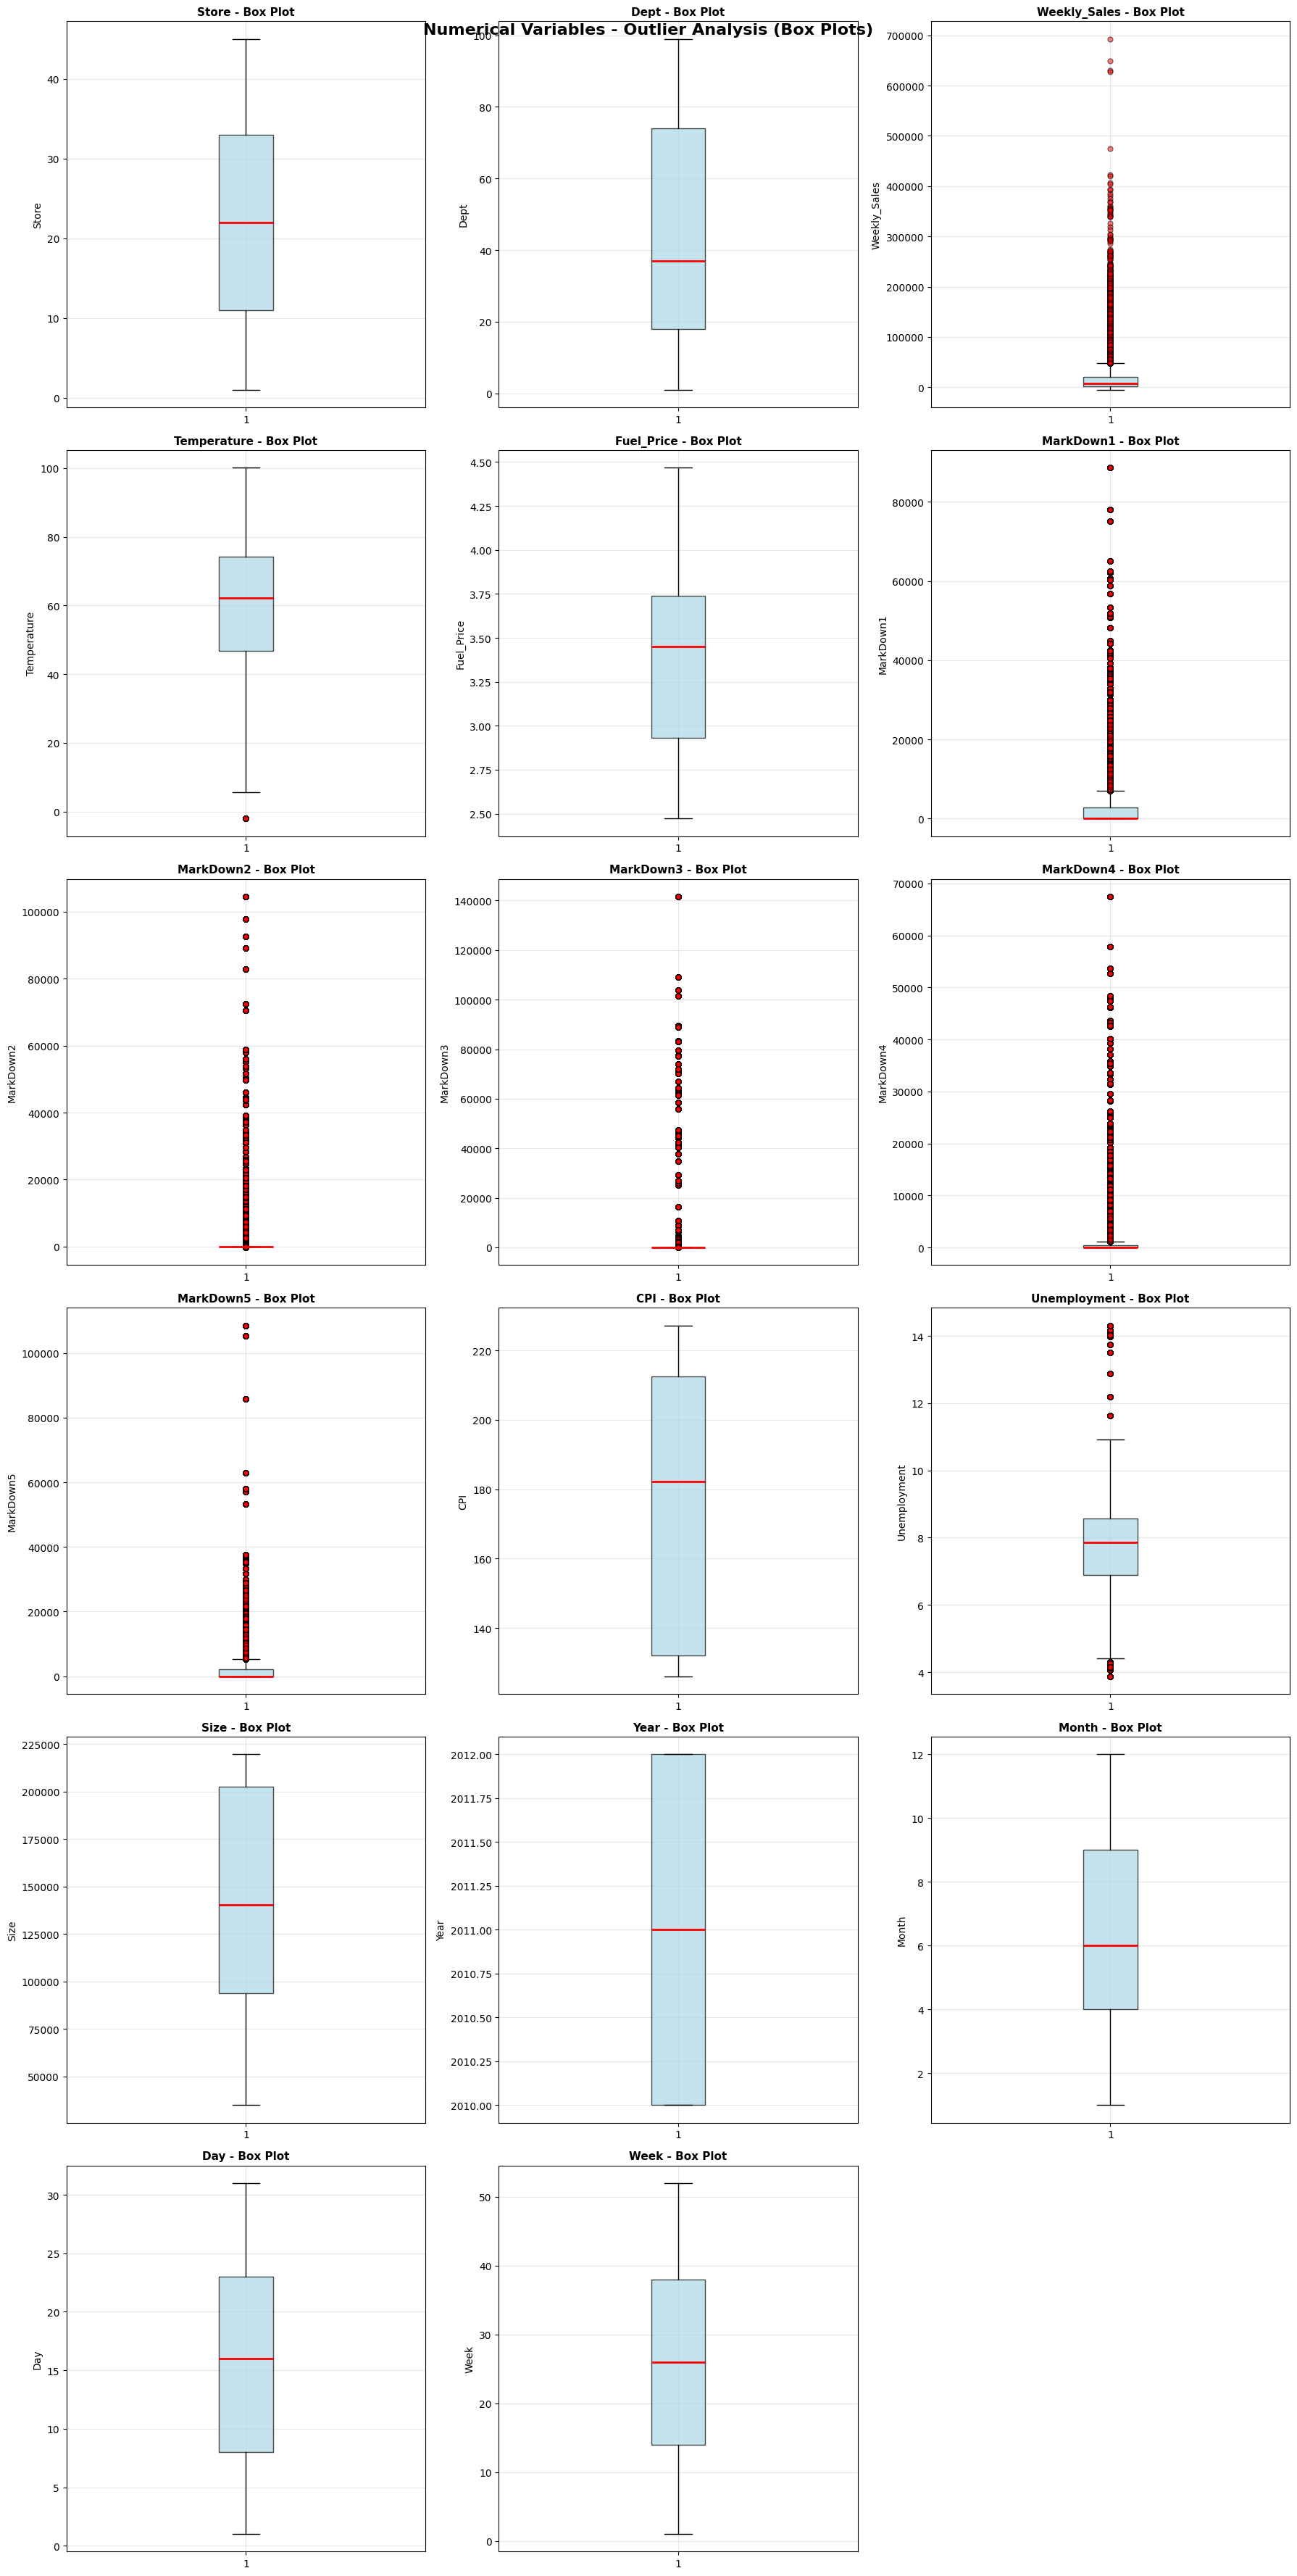

In [59]:
# Analisis Outlier (Box Plot)
if len(numerical_columns) > 0:
    print("\n\nOUTLIER ANALYSIS - BOX PLOTS")
    print("-" * 40)

    n_num_cols = len(numerical_columns)
    num_rows = (n_num_cols + 2) // 3  # Menghitung jumlah baris
    num_cols = 3

    # Box Plots
    fig_box, axes_box = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))
    fig_box.suptitle('Numerical Variables - Outlier Analysis (Box Plots)', fontsize=16, fontweight='bold', y=0.98)

    axes_box = axes_box.flatten() if n_num_cols > 1 else [axes_box]

    for i, col in enumerate(numerical_columns):
        if i < len(axes_box):
            data_col = df.select(col).rdd.flatMap(lambda x: x).collect()

            # Box Plot
            box_plot = axes_box[i].boxplot(data_col, patch_artist=True,
                                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                                           medianprops=dict(color='red', linewidth=2),
                                           flierprops=dict(marker='o', markerfacecolor='red',
                                                           markersize=5, alpha=0.5))

            axes_box[i].set_title(f'{col} - Box Plot', fontweight='bold', fontsize=11)
            axes_box[i].set_ylabel(col)
            axes_box[i].grid(True, alpha=0.3)

    for i in range(n_num_cols, len(axes_box)):
        axes_box[i].set_visible(False)

    plt.tight_layout()
    plt.show()

In [60]:
print("\nOutlier Analysis:")
for col in numerical_columns:
    q1 = df.approxQuantile(col, [0.25], 0.05)[0]
    q3 = df.approxQuantile(col, [0.75], 0.05)[0]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df.filter((F.col(col) < lower_bound) | (F.col(col) > upper_bound)).count()
    total = df.count()
    percent_outliers = (outliers / total) * 100
    print(f"{col}: {percent_outliers:.2f}% outliers")


Outlier Analysis:
Store: 0.00% outliers
Dept: 0.00% outliers
Weekly_Sales: 9.55% outliers
Temperature: 0.02% outliers
Fuel_Price: 0.00% outliers
MarkDown1: 15.79% outliers
MarkDown2: 25.77% outliers
MarkDown3: 20.09% outliers
MarkDown4: 21.51% outliers
MarkDown5: 10.83% outliers
CPI: 0.00% outliers
Unemployment: 7.62% outliers
Size: 0.00% outliers
Year: 0.00% outliers
Month: 0.00% outliers
Day: 0.00% outliers
Week: 0.00% outliers


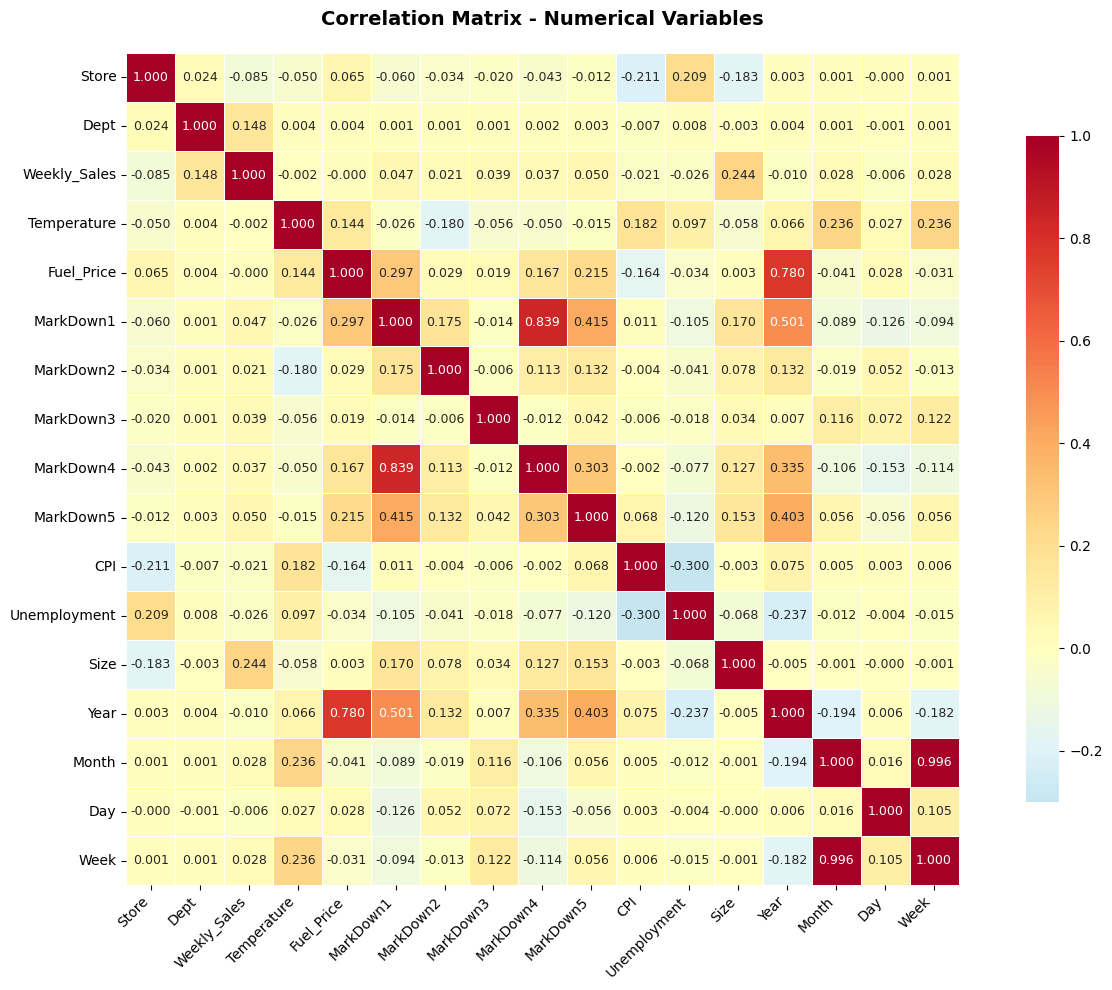

In [61]:
# Korelasi Fitur
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def compute_correlation(df, numerical_columns, target_column='Weekly_Sales'):
    assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
    df_assembled = assembler.transform(df)
    correlation_matrix = Correlation.corr(df_assembled, "features").head()[0]
    corr_array = correlation_matrix.toArray()
    corr_df = pd.DataFrame(corr_array, columns=numerical_columns, index=numerical_columns)
    return corr_df

correlation_matrix = compute_correlation(df, numerical_columns)

# Menampilkan Heatmap Korelasi
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.3f', annot_kws={'size': 9})
plt.title('Correlation Matrix - Numerical Variables', fontweight='bold', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
# Top Correlations with Weekly_Sales
target_corr = correlation_matrix['Weekly_Sales'].sort_values(ascending=False)
print("\nTop Correlations with Weekly_Sales:")
print(target_corr.head(10))


Top Correlations with Weekly_Sales:
Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
MarkDown5       0.050465
MarkDown1       0.047172
MarkDown3       0.038562
MarkDown4       0.037467
Month           0.028409
Week            0.027673
MarkDown2       0.020716
Name: Weekly_Sales, dtype: float64


In [63]:
from pyspark.sql import functions as F

# Statistik Deskriptif untuk Weekly_Sales
print("\n=== STATISTICAL INSIGHTS ===")
mean_weekly_sales = df.select(F.mean('Weekly_Sales')).collect()[0][0]
std_weekly_sales = df.select(F.stddev('Weekly_Sales')).collect()[0][0]
min_weekly_sales = df.select(F.min('Weekly_Sales')).collect()[0][0]
max_weekly_sales = df.select(F.max('Weekly_Sales')).collect()[0][0]

print(f"Weekly Sales - Mean: ${mean_weekly_sales:,.2f}")
print(f"Weekly Sales - Std:  ${std_weekly_sales:,.2f}")
print(f"Weekly Sales - Min:  ${min_weekly_sales:,.2f}")
print(f"Weekly Sales - Max:  ${max_weekly_sales:,.2f}")

# Markdown Impact Analysis
print("\nMARKDOWN IMPACT ANALYSIS:")
print("-" * 25)
for markdown in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    corr_val = df.stat.corr('Weekly_Sales', markdown)
    avg_markdown = df.select(F.avg(markdown)).collect()[0][0]
    print(f"{markdown}: Correlation={corr_val:.3f}, Avg=${avg_markdown:.2f}")

# Feature Importance Insights - Based on correlation strength
print("\n=== FEATURE IMPORTANCE INSIGHTS ===")
correlation_matrix = df.toPandas()[numerical_columns].corr()
strong_features = correlation_matrix['Weekly_Sales'][abs(correlation_matrix['Weekly_Sales']) > 0.5]
strong_features = strong_features.drop('Weekly_Sales')

if len(strong_features) > 0:
    print(f"Found {len(strong_features)} features with strong correlation (>0.5):")
    for feature, corr in strong_features.items():
        print(f"  - {feature}: {corr:.3f}")
else:
    print("No features show strong correlation (>0.5) with Weekly_Sales")



=== STATISTICAL INSIGHTS ===
Weekly Sales - Mean: $15,981.26
Weekly Sales - Std:  $22,711.18
Weekly Sales - Min:  $-4,988.94
Weekly Sales - Max:  $693,099.36

MARKDOWN IMPACT ANALYSIS:
-------------------------
MarkDown1: Correlation=0.047, Avg=$2590.07
MarkDown2: Correlation=0.021, Avg=$879.97
MarkDown3: Correlation=0.039, Avg=$468.09
MarkDown4: Correlation=0.037, Avg=$1083.13
MarkDown5: Correlation=0.050, Avg=$1662.77

=== FEATURE IMPORTANCE INSIGHTS ===
No features show strong correlation (>0.5) with Weekly_Sales


In [139]:
# HOLIDAY IMPACT
if 'IsHoliday' in df.columns:
      holiday_sales = df.filter(df['IsHoliday'] == True).agg(F.mean('Weekly_Sales')).collect()[0][0]
      regular_sales = df.filter(df['IsHoliday'] == False).agg(F.mean('Weekly_Sales')).collect()[0][0]

      holiday_impact = ((holiday_sales / regular_sales - 1) * 100)
      print("Holiday Impact:")
      print(f"  - Holiday weeks avg sales: ${holiday_sales:,.2f}")
      print(f"  - Regular weeks avg sales: ${regular_sales:,.2f}")
      print(f"  - Holiday impact: {holiday_impact:.1f}%")


Holiday Impact:
  - Holiday weeks avg sales: $17,035.82
  - Regular weeks avg sales: $15,901.45
  - Holiday impact: 7.1%


# Feature Scaling / Normalization

In [140]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

# Membuat fitur vektor untuk kolom numerik yang akan di-scale
vec_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
df = vec_assembler.transform(df)

# Standarisasi fitur dengan StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)
df.show(5)



+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+------------------+----+------+----+-----+---+----+--------------------+--------------------+
|Store|      Date|Dept|Weekly_Sales|IsHoliday|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|        CPI|Unemployment|IsHoliday_features|Type|  Size|Year|Month|Day|Week|            features|     scaled_features|
+-----+----------+----+------------+---------+-----------+----------+---------+---------+---------+---------+---------+-----------+------------+------------------+----+------+----+-----+---+----+--------------------+--------------------+
|    1|2010-02-05|   1|     24924.5|    false|      42.31|     2.572|      0.0|      0.0|      0.0|      0.0|      0.0|211.0963582|       8.106|             false|   A|151315|2010|    2|  5|   5|[1.0,1.0,24924.5,...|[0.07821484080532...|
|    1|2010-02-12|   1|    46039.49|     true|  

# split data

In [141]:
# Membagi data menjadi training set (70%) dan test set (30%)
train_data_assembled, test_data_assembled = df.randomSplit([0.7, 0.3], seed=1234)

# Menampilkan jumlah baris dalam masing-masing set
print(f"Jumlah baris data pelatihan: {train_data_assembled.count()}")
print(f"Jumlah baris data pengujian: {test_data_assembled.count()}")


Jumlah baris data pelatihan: 295547
Jumlah baris data pengujian: 126023


In [146]:
# Menampilkan beberapa baris pertama dari data pelatihan dengan fitur baru
train_data_assembled.select("Store", "Dept", "Date", "Weekly_Sales", "features").show(5)

# Menampilkan beberapa baris pertama dari data uji dengan fitur baru
test_data_assembled.select("Store", "Dept", "Date", "Weekly_Sales", "features").show(5)


+-----+----+----------+------------+--------------------+
|Store|Dept|      Date|Weekly_Sales|            features|
+-----+----+----------+------------+--------------------+
|    1|   3|2010-02-05|    13740.12|[1.0,3.0,13740.12...|
|    1|   4|2010-02-05|    39954.04|[1.0,4.0,39954.04...|
|    1|   6|2010-02-05|     5749.03|[1.0,6.0,5749.03,...|
|    1|   7|2010-02-05|    21084.08|[1.0,7.0,21084.08...|
|    1|   8|2010-02-05|    40129.01|[1.0,8.0,40129.01...|
+-----+----+----------+------------+--------------------+
only showing top 5 rows
+-----+----+----------+------------+--------------------+
|Store|Dept|      Date|Weekly_Sales|            features|
+-----+----+----------+------------+--------------------+
|    1|   1|2010-02-05|     24924.5|[1.0,1.0,24924.5,...|
|    1|   2|2010-02-05|    50605.27|[1.0,2.0,50605.27...|
|    1|   5|2010-02-05|    32229.38|[1.0,5.0,32229.38...|
|    1|  23|2010-02-05|    24146.49|[1.0,23.0,24146.4...|
|    1|  26|2010-02-05|    11737.12|[1.0,26.0,11

# MODELLING

RANDOM FOREST REGRESSION

In [145]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Membuat model regresi Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="Weekly_Sales")

# Melatih model dengan data pelatihan
rf_model = rf.fit(train_data_assembled)

# Melakukan prediksi pada data uji
rf_predictions = rf_model.transform(test_data_assembled)

# Menampilkan hasil prediksi
rf_predictions.select("Store", "Dept", "Date", "Weekly_Sales", "prediction").show(5)


+-----+----+----------+------------+------------------+
|Store|Dept|      Date|Weekly_Sales|        prediction|
+-----+----+----------+------------+------------------+
|    1|   1|2010-02-05|     24924.5|21220.033305425386|
|    1|   2|2010-02-05|    50605.27| 48834.40163554636|
|    1|   5|2010-02-05|    32229.38| 24915.73481022996|
|    1|  23|2010-02-05|    24146.49|14760.424077280517|
|    1|  26|2010-02-05|    11737.12| 8995.233948953373|
+-----+----+----------+------------+------------------+
only showing top 5 rows


In [147]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Evaluasi model dengan RMSE dan R-squared
evaluator_rmse_rf = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="rmse")
evaluator_r2_rf = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="r2")

# Menghitung RMSE
rmse_rf = evaluator_rmse_rf.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rmse_rf}")

# Menghitung R-squared
r2_rf = evaluator_r2_rf.evaluate(rf_predictions)
print(f"Random Forest R-squared: {r2_rf}")

# Menghitung MAE (Mean Absolute Error)
y_test_rf = rf_predictions.select("Weekly_Sales").rdd.flatMap(lambda x: x).collect()
y_pred_rf = rf_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
print(f"Random Forest MAE: {mae_rf}")

Random Forest RMSE: 7465.994229067068
Random Forest R-squared: 0.8898199719861325
Random Forest MAE: 4224.178601093522


XGBOOST

In [149]:
# Instalasi xgboost jika belum diinstal
# !pip install xgboost

# Import library yang diperlukan
import xgboost as xgb
import pandas as pd
import numpy as np

# Mengonversi data ke Pandas
train_pd = train_data_assembled.select("features", "Weekly_Sales").toPandas()
test_pd = test_data_assembled.select("features", "Weekly_Sales").toPandas()

# Mengambil fitur (X) dan target (y) dari DataFrame
X_train = pd.DataFrame(train_pd['features'].to_list())  # Konversi list ke DataFrame
y_train = train_pd['Weekly_Sales']
X_test = pd.DataFrame(test_pd['features'].to_list())
y_test = test_pd['Weekly_Sales']

# Membuat DMatrix (format yang diperlukan untuk XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Menentukan parameter untuk XGBoost
params = {
   'objective': 'reg:squarederror',  # Untuk regresi
    'eval_metric': 'rmse',  # Evaluasi berdasarkan RMSE
}

# Melatih model XGBoost
num_round = 100  # Jumlah iterasi
xgb_model = xgb.train(params, dtrain, num_round)

# Melakukan prediksi pada data uji
y_pred = xgb_model.predict(dtest)



In [150]:
# Melakukan prediksi pada data uji
y_pred_default = xgb_model.predict(dtest)

# Mengonversi hasil prediksi ke DataFrame untuk menampilkan
predictions_df = pd.DataFrame({
    'Actual': y_test,  # Nilai aktual
    'Predicted': y_pred_default  # Hasil prediksi
})

# Menampilkan 5 baris pertama hasil prediksi
print(predictions_df.head(5))


     Actual     Predicted
0  24924.50  24697.900391
1  50605.27  50231.269531
2  32229.38  32530.763672
3  24146.49  24240.644531
4  11737.12  11796.833008


In [151]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Melakukan prediksi pada data pelatihan
y_train_pred = xgb_model.predict(dtrain)

# Menghitung MSE secara manual
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)  # Mengambil akar kuadrat dari MSE

# Menghitung R-squared
r2_xgb = r2_score(y_test, y_pred)
mae_xgb_default = mean_absolute_error(y_test, y_pred_default)

print(f"XGBoost uji RMSE: {rmse_xgb}")
print(f"XGBoost uji R-squared: {r2_xgb}")
print(f"XGBoost MAE (Default): {mae_xgb_default}")

XGBoost uji RMSE: 2089.2310720100036
XGBoost uji R-squared: 0.9913721908232104
XGBoost MAE (Default): 189.85302370362226


[0]	train-rmse:16055.87140	test-rmse:15824.60283
[1]	train-rmse:11354.66993	test-rmse:11175.39001
[2]	train-rmse:8101.13428	test-rmse:7971.21471
[3]	train-rmse:5857.88691	test-rmse:5776.30473
[4]	train-rmse:4353.46517	test-rmse:4303.18680
[5]	train-rmse:3357.02206	test-rmse:3361.62574
[6]	train-rmse:2709.20953	test-rmse:2784.12397
[7]	train-rmse:2314.51633	test-rmse:2411.75445
[8]	train-rmse:2077.96109	test-rmse:2206.76534
[9]	train-rmse:1930.81811	test-rmse:2104.69234
[10]	train-rmse:1844.14847	test-rmse:2046.55262
[11]	train-rmse:1789.42168	test-rmse:2013.50216
[12]	train-rmse:1736.68707	test-rmse:2017.53220
[13]	train-rmse:1684.74961	test-rmse:2007.34485
[14]	train-rmse:1642.24543	test-rmse:2036.68304
[15]	train-rmse:1624.45656	test-rmse:2039.94854
[16]	train-rmse:1605.35333	test-rmse:2044.02501
[17]	train-rmse:1557.14829	test-rmse:2018.50238
[18]	train-rmse:1536.80373	test-rmse:2021.71945
[19]	train-rmse:1519.43156	test-rmse:2002.38591
[20]	train-rmse:1504.67425	test-rmse:1999.5357

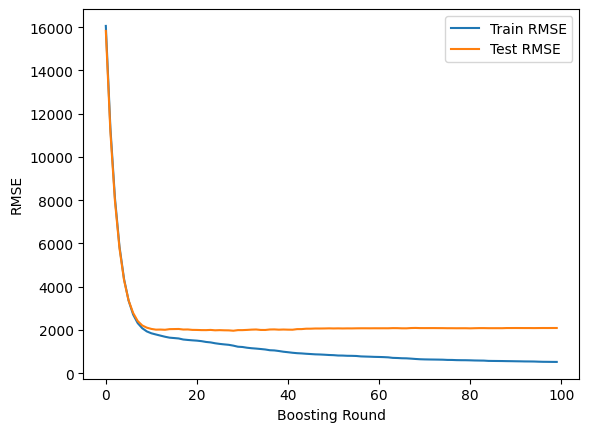

In [152]:
import matplotlib.pyplot as plt

# Mencatat metrik selama pelatihan
evals_result = {}
xgb_model = xgb.train(params, dtrain, num_round, evals=[(dtrain, 'train'), (dtest, 'test')], evals_result=evals_result)

# Plotting learning curves
plt.plot(evals_result['train']['rmse'], label='Train RMSE')
plt.plot(evals_result['test']['rmse'], label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.show()


GBT Regressor

In [155]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler

# Membuat model Gradient Boosting Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="Weekly_Sales")

# Melatih model dengan data pelatihan
gbt_model = gbt.fit(train_data_assembled)

# Melakukan prediksi pada data uji
predictions_gbt = gbt_model.transform(test_data_assembled)

# Menampilkan hasil prediksi (contoh 5 hasil)
predictions_gbt.select("Store", "Dept", "Date", "Weekly_Sales", "prediction").show(5)


+-----+----+----------+------------+------------------+
|Store|Dept|      Date|Weekly_Sales|        prediction|
+-----+----+----------+------------+------------------+
|    1|   1|2010-02-05|     24924.5|25219.694671930585|
|    1|   2|2010-02-05|    50605.27| 47526.97634454952|
|    1|   5|2010-02-05|    32229.38| 34405.69232126056|
|    1|  23|2010-02-05|    24146.49| 25100.98641999676|
|    1|  26|2010-02-05|    11737.12|12198.503755796019|
+-----+----+----------+------------+------------------+
only showing top 5 rows


In [156]:
from sklearn.metrics import mean_absolute_error
import numpy as np

evaluator_rmse = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Weekly_Sales", predictionCol="prediction", metricName="r2")

# Menghitung RMSE
rmse_gbt = evaluator_rmse.evaluate(predictions_gbt)
print(f"GBT Regressor RMSE: {rmse_gbt}")

# Menghitung R-squared
r2_gbt = evaluator_r2.evaluate(predictions_gbt)
print(f"GBT Regressor R-squared: {r2_gbt}")

# Menghitung MAE (Mean Absolute Error)
y_test_gbt = predictions_gbt.select("Weekly_Sales").rdd.flatMap(lambda x: x).collect()
y_pred_gbt = predictions_gbt.select("prediction").rdd.flatMap(lambda x: x).collect()

mae_gbt = mean_absolute_error(y_test_gbt, y_pred_gbt)
print(f"GBT Regressor MAE: {mae_gbt}")

GBT Regressor RMSE: 3380.5242127204806
GBT Regressor R-squared: 0.9774110689167953
GBT Regressor MAE: 1022.0307543665031


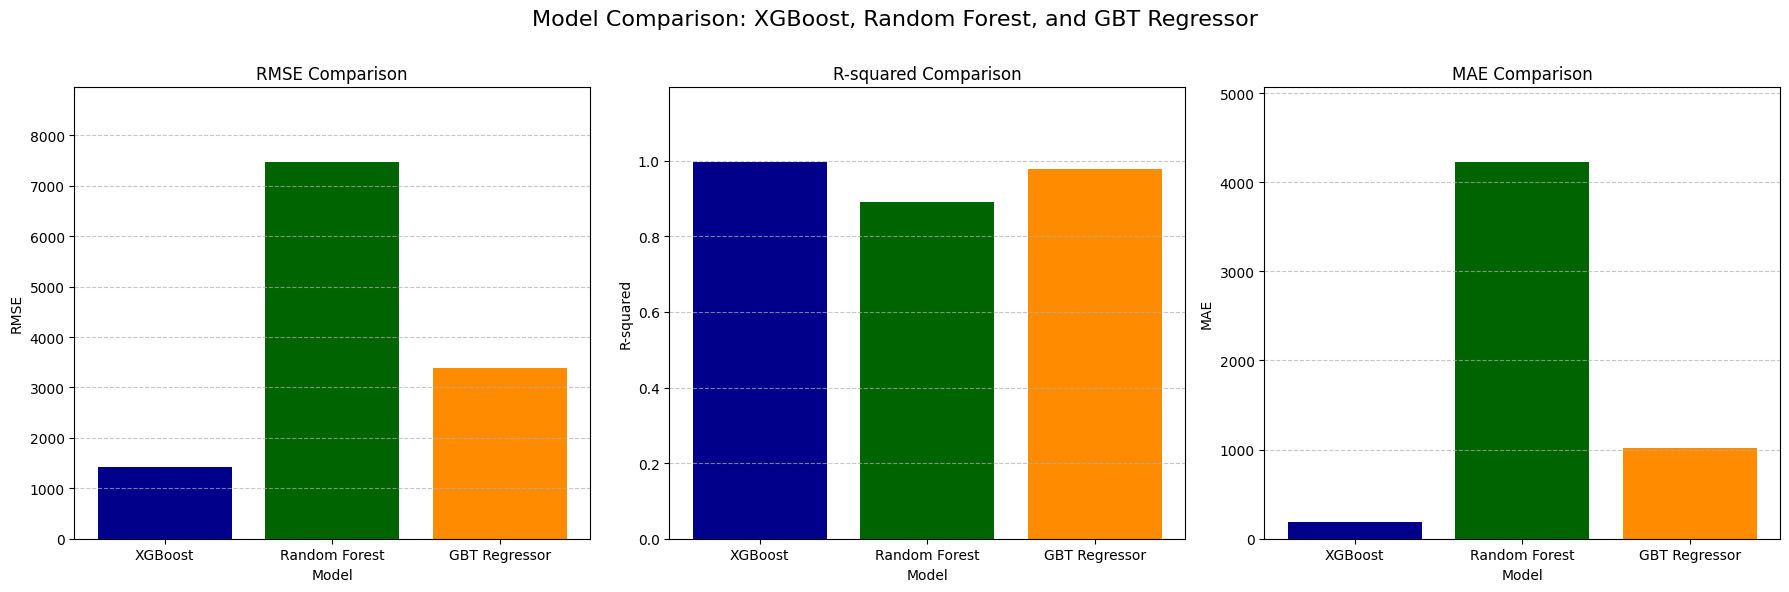

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Data hasil evaluasi model (nilai RMSE, R-squared, dan MAE untuk setiap model)
metrics = ['RMSE', 'R-squared', 'MAE']

# Hasil evaluasi (asumsi Anda sudah menjalankan ketiga model dan mendapatkan hasilnya)
# Misalnya hasil untuk XGBoost, Random Forest, dan GBT
results = {
    'XGBoost': [rmse_xgb_default, r2_xgb_default, mae_xgb_default],
    'Random Forest': [rmse_rf, r2_rf, mae_rf],
    'GBT Regressor': [rmse_gbt, r2_gbt, mae_gbt]
}

# Menyiapkan plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot untuk RMSE, R-squared, dan MAE
for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_values = [results[model][i] for model in results]
    ax.bar(results.keys(), metric_values, color=['darkblue', 'darkgreen', 'darkorange'])

    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_ylim(0, max(metric_values) * 1.2)  # Menyesuaikan agar grafik tidak terlalu sesak
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Menambahkan judul umum
fig.suptitle('Model Comparison: XGBoost, Random Forest, and GBT Regressor', fontsize=16)

# Menampilkan plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Agar judul umum tidak tumpang tindih
plt.show()
